In [173]:
import os
import sys

import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
# from torch.utils.tensorboard import SummaryWriter

# import matplotlib.pyplot as plt
import numpy as np
import clip
sys.path.append('../.')
from Metrics import nmi, acc, base_kmeans_model_evaluation, kmeans_with_init
from networks import CustomCLIP, load_clip_to_cpu
from lr_scheduler import ConstantWarmupScheduler
from torch.autograd import Variable
import argparse
from sklearn.cluster import KMeans
import pandas as pd
batch_size = 50
num_classes =40

In [174]:
backbone_name = "ViT-B/16"
device = torch.device('cuda') if torch.cuda.is_available() else "cpu"
clip_model, preprocess = load_clip_to_cpu(backbone_name)
n_ctx=16
model = CustomCLIP(clip_model, num_classes, n_ctx=n_ctx)

for name, param in model.named_parameters():
    if "prompt_learner" not in name:
        param.requires_grad_(False)

model.to(device)
print('done')
#mean=(0.48145466, 0.4578275, 0.40821073), std=(0.26862954, 0.26130258, 0.27577711)

Initializing class-specific contexts
Initial context: "age of personX X X X X X X X X X X X X X X X"
Number of context words (tokens): 16
done


In [157]:
trainset = torchvision.datasets.CIFAR10(root='../data', train=True,
                                        download=True, transform=preprocess) 

testset = torchvision.datasets.CIFAR10(root='../data', train=False,
                                        download=True, transform=preprocess)

trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=False)

testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                          shuffle=False)
concatset = torch.utils.data.ConcatDataset([trainset, testset])
concatloader = torch.utils.data.DataLoader(concatset, batch_size=batch_size,
                                         shuffle=False)


Files already downloaded and verified
Files already downloaded and verified


In [31]:
trainset = torchvision.datasets.STL10(
    root='../data', split='train', download=True,
    transform=preprocess)
testset = torchvision.datasets.STL10(
    root='../data', split='test', download=True,
    transform=preprocess)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=False)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                          shuffle=False)
concatset = torch.utils.data.ConcatDataset([trainset, testset])
concatloader = torch.utils.data.DataLoader(concatset, batch_size=batch_size,
                                         shuffle=False)



Files already downloaded and verified
Files already downloaded and verified


In [171]:

testset = custom_dataset(root_dir='/database/daehyeon/Stanford40/JPEGImages', transform=preprocess)
testloader = DataLoader(
    dataset=testset, 
    batch_size=batch_size,
    shuffle=False)

In [165]:
model.eval()
data_loader = testloader
num_classes = 40
num_cluster = 40
with torch.no_grad():
    dataset_size = len(data_loader.dataset)
    datas = np.zeros([dataset_size, 512])
    label_true = np.zeros(dataset_size)
    ii = 0
    for x, target in data_loader:
        b = x.shape[0]
        x = Variable(x).cuda()
        image_representation = model.image_encoder(x.type(model.dtype))
#         image_representation = image_representation / \
#             image_representation.norm(dim=-1, keepdim=True)
        u = image_representation.cpu()
        datas[ii * data_loader.batch_size:(ii + 1) *
              data_loader.batch_size, :] = u.data.numpy()
        label_true[ii * data_loader.batch_size:(ii + 1)
                   * data_loader.batch_size] = target.numpy()
        ii = ii + 1

In [159]:
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import normalized_mutual_info_score, adjusted_rand_score
from torch.autograd import Variable
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
nmi = normalized_mutual_info_score
# agg = AgglomerativeClustering(n_clusters=10)
# assignment = agg.fit_predict(datas[:100])
kmeans = KMeans(n_clusters=num_classes, random_state=0).fit(datas)


### k_mean centroids 불러오기

In [160]:
centroids = kmeans.cluster_centers_
centroid_target = np.array([num_classes for i in range(num_classes)])

### 저장된 text centroids 불러오기

In [175]:
reload = 3399
print('reload_model: from {} epoch'.format(reload))
cluster_name = False
dataset_name = 'stanford40'
lr = 3e-4
optimizer = torch.optim.Adam(
    model.parameters(),
    lr=lr,
    weight_decay=5e-4,
    betas=(0.9, 0.999),
)

num_centroids = 1
clip_backbone = backbone_name
if cluster_name:
    model_fp = os.path.join('../save', "{}_".format(cluster_name)+'{}cent'.format(str(num_centroids)),"checkpoint_{}.tar".format(reload))
else:
    model_fp = os.path.join('../save',"{}_".format(clip_backbone.replace('/', '_'))+"{}_".format(dataset_name)+'{}cent'.format(str(num_centroids)),"checkpoint_{}.tar".format(reload))
print(model_fp)
checkpoint = torch.load(model_fp)
model.load_state_dict(checkpoint['net'])
optimizer.load_state_dict(checkpoint['optimizer'])

with torch.no_grad():
    model.eval()

    prompts = model.prompt_learner()
    tokenized_prompts = model.tokenized_prompts
    # kdkd
    for i in range(len(prompts)):
        text_feature = model.text_encoder(prompts[i], tokenized_prompts)
        text_feature = text_feature / \
            text_feature.norm(dim=-1, keepdim=True)
        if i == 0:
            text_features = text_feature.expand(1, -1, -1)
        else:
            text_feature = text_feature.expand(1, -1, -1)
            text_features = torch.cat((text_features, text_feature), dim=0)
    text_centroids = text_features.mean(dim=0)
    


reload_model: from 3399 epoch
../save/ViT-B_16_stanford40_1cent/checkpoint_3399.tar


In [176]:
knn = cosine_kmeans_with_init

new_label, acc, nmi = knn(
            model, testloader, num_classes, text_centroids)
# 9855,9645

image_ACC 0.5851867394041125
image_NMI 0.6349463262426848


In [130]:
kmean_centroids = kmeans.cluster_centers_
text_centroids = text_centroids.cpu().numpy()
centroids_target = np.array([num_classes for i in range(num_classes)])
text_centroids_target = np.array([num_classes+1 for i in range(num_classes)])
total_data =  np.concatenate((datas[:1000],kmean_centroids,text_centroids))
total_target = np.concatenate((label_true[:1000],centroids_target,text_centroids_target))
total_data.shape

(1020, 512)

In [139]:
# from sklearn.decomposition import PCA
# pca = PCA(n_components=2)
# tsne_np = pca.fit_transform(total_data)
# tsne_df = pd.DataFrame(data = tsne_np
#              , columns = ['component 0', 'component 1'])
# tsne_df['target'] = total_target

In [146]:
tsne_np = TSNE(n_components=2).fit_transform(total_data)
tsne_df = pd.DataFrame(tsne_np, columns = ['component 0', 'component 1'])
tsne_df['target'] = total_target
tsne_df

,component 0,component 1,target
0,15.647672,31.894279,6.0
1,17.766068,-16.434462,7.0
2,1.951777,15.069803,5.0
3,-33.798859,20.909086,0.0
4,4.781252,3.588099,3.0
...,...,...,...
1015,-5.652595,-6.769750,11.0
1016,-5.762086,-6.513533,11.0
1017,-5.129335,-7.027492,11.0
1018,-6.315005,-6.974764,11.0


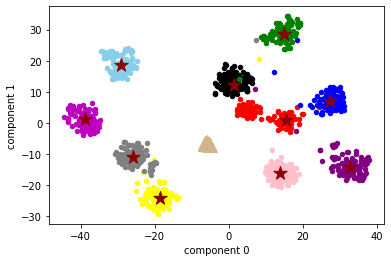

In [147]:
import matplotlib.pyplot as plt
label_true = label_true.astype(int)
index_list = []
tsne_df_0 = tsne_df[tsne_df['target'] == 0]
tsne_df_1 = tsne_df[tsne_df['target'] == 1]
tsne_df_2 = tsne_df[tsne_df['target'] == 2]
tsne_df_3 = tsne_df[tsne_df['target'] == 3]
tsne_df_4 = tsne_df[tsne_df['target'] == 4]
tsne_df_5 = tsne_df[tsne_df['target'] == 5]
tsne_df_6 = tsne_df[tsne_df['target'] == 6]
tsne_df_7 = tsne_df[tsne_df['target'] == 7]
tsne_df_8 = tsne_df[tsne_df['target'] == 8]
tsne_df_9 = tsne_df[tsne_df['target'] == 9]
tsne_df_10 = tsne_df[tsne_df['target'] == 10]
tsne_df_11 = tsne_df[tsne_df['target'] == 11]

plt.scatter(tsne_df_0['component 0'], tsne_df_0['component 1'], s=20, color = 'skyblue', label = 'car')
plt.scatter(tsne_df_1['component 0'], tsne_df_1['component 1'], s=20,color = 'purple', label = 'truck')
plt.scatter(tsne_df_2['component 0'], tsne_df_2['component 1'], s=20, color = 'yellow', label = 'bird')
plt.scatter(tsne_df_3['component 0'], tsne_df_3['component 1'], s=20, color = 'red', label = 'a')
plt.scatter(tsne_df_4['component 0'], tsne_df_4['component 1'], s=20,color = 'blue', label = 'b')
plt.scatter(tsne_df_5['component 0'], tsne_df_5['component 1'], s=20, color = 'black', label = 'c')
plt.scatter(tsne_df_6['component 0'], tsne_df_6['component 1'], s=20, color = 'green', label = 'd')
plt.scatter(tsne_df_7['component 0'], tsne_df_7['component 1'], s=20, color = 'pink', label = 'e')
plt.scatter(tsne_df_8['component 0'], tsne_df_8['component 1'], s=20, color = 'm', label = 'e')
plt.scatter(tsne_df_9['component 0'], tsne_df_9['component 1'], s=20,color = 'gray', label = 'e')
plt.scatter(tsne_df_10['component 0'], tsne_df_10['component 1'], s=200,color = 'darkred', marker='*', label = 'centroids')
plt.scatter(tsne_df_11['component 0'], tsne_df_11['component 1'], s=200,color = 'tan', marker='^', label = 'text_centroids')
plt.xlabel('component 0')
plt.ylabel('component 1')
# plt.legend()
plt.show()




In [185]:
def compute_distances(clusters,data):
    """
    Compute the distance between each test point in X and each training point
    in self.X_train using no explicit loops.

    Input / Output: Same as compute_distances_two_loops
    """
    num_cluster = clusters.shape[0]
    num_data= data.shape[0]
    dists = np.zeros((num_cluster, num_data))
    C_square = clusters**2
    C_square_sum = np.sum(C_square,axis=1)
    D_square = data**2
    D_square_sum = np.sum(D_square,axis=1)
    CD = clusters@data.T
    dists = np.sqrt(C_square_sum.reshape(-1,1)+D_square_sum.reshape(1,-1)-2*CD)
    
    
    #########################################################################
    #                         END OF YOUR CODE                              #
    #########################################################################
    return dists

In [192]:
print(datas.shape)
print(kmean_centroids.shape)
k_dists = compute_distances(kmean_centroids,datas[:1000])
k_dists.shape

(9532, 512)
(10, 512)


(10, 1000)

In [193]:
label_true[:1000]

array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9.,  8., 10., 11.,
       12., 13., 14., 15., 16., 17., 16., 18., 16., 19., 19., 20., 16.,
        8.,  5., 13., 21., 22., 23.,  3., 24., 22., 21.,  8.,  9., 25.,
       26., 27., 20., 13., 28.,  4., 15., 28.,  3., 26., 16., 26.,  0.,
       28., 23., 10.,  6.,  5., 22., 19., 20., 29., 20.,  1., 30., 14.,
       18.,  9., 23.,  6., 26., 24., 21., 15., 31.,  1., 32., 15.,  6.,
        6.,  7., 21., 11.,  4., 11., 26., 24.,  3., 33.,  0.,  6., 31.,
       25., 23., 20., 14.,  0., 17., 26., 21., 20., 13.,  9., 34., 17.,
       15., 23.,  9.,  5., 10., 34., 13., 35.,  4., 12., 22., 29., 36.,
       37., 19., 32., 11., 17., 10.,  9.,  7., 14., 22., 14., 19.,  6.,
       26., 16., 34.,  2., 24.,  4., 16.,  1.,  4., 15., 17., 34., 32.,
       26.,  4., 14.,  3.,  2., 30., 19.,  2.,  8., 13., 23., 29.,  2.,
       35., 14.,  2.,  3.,  9., 35.,  2., 35., 34.,  3., 20., 14.,  6.,
       14.,  2., 35.,  1.,  8., 22., 30., 30.,  8.,  6.,  1., 34

In [ ]:
label_true

In [23]:
acc(label_true,assignment,10)

0.921875

In [11]:
kmeans = KMeans(n_clusters=10, random_state=0).fit(datas[:100])

In [7]:
# print(kmeans.cluster_centers_.shape)
# print(kmeans.predict(datas) == kmeans.labels_)
# print(kmeans.labels_)
print(kmeans.transform(datas))

[[0.35680111 0.47526313 0.46690374 ... 0.5336978  0.4927107  0.42369088]
 [0.69727243 0.67971339 0.59437052 ... 0.57633769 0.46104175 0.68428553]
 [0.60895998 0.58775496 0.48862205 ... 0.51733521 0.40593188 0.61013959]
 ...
 [0.40054516 0.54009568 0.58835631 ... 0.63883902 0.61827266 0.53744563]
 [0.54475308 0.55552519 0.40158815 ... 0.50857146 0.52068553 0.55780734]
 [0.48814425 0.36013382 0.52702188 ... 0.56496387 0.56033897 0.50310673]]


In [8]:
# s1= pd.Series(kmeans.labels_)
# s2 = pd.Series(kmeans.transform(datas))
labels = kmeans.labels_
dists = kmeans.transform(datas)
dists.shape

(10000, 10)

In [9]:
dists_list = [item for item in dists]

In [10]:
# df = pd.DataFrame({'labels':labels,'dists':dists})
df2 = pd.DataFrame([])
df2["dists"] = dists_list
df2["labels"] = labels

In [11]:
num = np.unique(labels, axis=0)
num = num.shape[0]
one_hot_labels = np.eye(num)[labels]
pred_distances = np.sum(dists*one_hot_labels,axis=-1)
df2["label_dists"] =pred_distances

In [12]:
df2

,dists,labels,label_dists
0,"[0.35680110851694136, 0.4752631341204175, 0.46...",0,0.356801
1,"[0.6972724319254127, 0.6797133945567855, 0.594...",8,0.461042
2,"[0.6089599818547916, 0.5877549570906977, 0.488...",8,0.405932
3,"[0.8466724361056555, 0.8368604059551397, 0.783...",4,0.678966
4,"[0.5023865200335534, 0.5617545758420154, 0.571...",6,0.333082
...,...,...,...
9995,"[0.4401861960889228, 0.520907047162295, 0.4790...",4,0.420178
9996,"[0.4163759781841375, 0.5359823521442594, 0.591...",0,0.416376
9997,"[0.40054516372967625, 0.5400956751862934, 0.58...",0,0.400545
9998,"[0.544753075679077, 0.5555251910066308, 0.4015...",2,0.401588


In [13]:
mean_std_list = []
label_dists_dict = {i:[] for i in range(10)}
for i in range(len(df2)):
    row = df2.iloc[i]
    label_dists_dict[row["labels"]].append(row["label_dists"])
for i in range(10):
    mean = np.mean(label_dists_dict[i])
    std = np.std(label_dists_dict[i])
    mean_std_list.append((mean,std))

In [14]:
df3 = df2

In [24]:
c = 0
df3 = df2
drop_list = []
for i in range(len(df3)):
    row = df3.iloc[i]
    label = row['labels']
    label_dists = row["label_dists"]
    mean,std = mean_std_list[label]
    if label_dists > mean + std:
        drop_list.append(i)        
df3 = df3.drop(drop_list)
df3

,dists,labels,label_dists
0,"[0.35680110851694136, 0.4752631341204175, 0.46...",0,0.356801
1,"[0.6972724319254127, 0.6797133945567855, 0.594...",8,0.461042
2,"[0.6089599818547916, 0.5877549570906977, 0.488...",8,0.405932
4,"[0.5023865200335534, 0.5617545758420154, 0.571...",6,0.333082
5,"[0.4531035314735096, 0.5646737477425801, 0.557...",6,0.442161
...,...,...,...
9995,"[0.4401861960889228, 0.520907047162295, 0.4790...",4,0.420178
9996,"[0.4163759781841375, 0.5359823521442594, 0.591...",0,0.416376
9997,"[0.40054516372967625, 0.5400956751862934, 0.58...",0,0.400545
9998,"[0.544753075679077, 0.5555251910066308, 0.4015...",2,0.401588


In [25]:
df2

,dists,labels,label_dists
0,"[0.35680110851694136, 0.4752631341204175, 0.46...",0,0.356801
1,"[0.6972724319254127, 0.6797133945567855, 0.594...",8,0.461042
2,"[0.6089599818547916, 0.5877549570906977, 0.488...",8,0.405932
3,"[0.8466724361056555, 0.8368604059551397, 0.783...",4,0.678966
4,"[0.5023865200335534, 0.5617545758420154, 0.571...",6,0.333082
...,...,...,...
9995,"[0.4401861960889228, 0.520907047162295, 0.4790...",4,0.420178
9996,"[0.4163759781841375, 0.5359823521442594, 0.591...",0,0.416376
9997,"[0.40054516372967625, 0.5400956751862934, 0.58...",0,0.400545
9998,"[0.544753075679077, 0.5555251910066308, 0.4015...",2,0.401588


In [23]:
for i,item in enumerate(mean_std_list):
    print(i,item[0]-item[1])
df3[10:20]

0 0.32628645782850874
1 0.3163808237156214
2 0.34482281072754295
3 0.382491448224148
4 0.3819461339852705
5 0.28991022751071893
6 0.32691559806199855
7 0.3640870895428254
8 0.3430247235495666
9 0.34471654669387874


,dists,labels,label_dists
11,"[0.7250531360392717, 0.7201171022048772, 0.608...",7,0.524090
12,"[0.3889949969522323, 0.4931255214222772, 0.531...",0,0.388995
13,"[0.44474712164426694, 0.3487112893266522, 0.51...",1,0.348711
16,"[0.3398366570675246, 0.48361564946962055, 0.51...",0,0.339837
17,"[0.527213369570509, 0.41029435447592527, 0.601...",1,0.410294
18,"[0.519113013804814, 0.5531415328250296, 0.4912...",8,0.389370
19,"[0.6179985421295174, 0.6574081372073094, 0.664...",6,0.419705
20,"[0.6607863862958878, 0.4846287838457465, 0.648...",1,0.484629
21,"[0.6569345207335286, 0.703503127073573, 0.6614...",4,0.525428
22,"[0.4917875263328082, 0.5225023114525862, 0.529...",5,0.369914


In [21]:
df2[13:17]

,dists,labels,label_dists
13,"[0.44474712164426694, 0.3487112893266522, 0.51...",1,0.348711
14,"[0.5636258764534159, 0.5569489013967642, 0.450...",7,0.305062
15,"[0.5451262543915986, 0.5665692895938854, 0.461...",8,0.323764
16,"[0.3398366570675246, 0.48361564946962055, 0.51...",0,0.339837


In [ ]:
filtered_index_list = df3.index.tolist()

In [ ]:
testset.data = testset.data[filtered_index_list]

In [ ]:
testset.targets = np.array(testset.targets)[filtered_index_list].tolist()

In [ ]:
print(testset.data.shape)
print(len(testset.targets))

In [22]:
label_dists_dict = {i:0 for i in range(10)}
print(label_dists_dict)
for i in range(len(df3)):
    row = df2.iloc[i]
    label_dists_dict[row["labels"]] += 1
label_dists_dict

{0: 0, 1: 0, 2: 0, 3: 0, 4: 0, 5: 0, 6: 0, 7: 0, 8: 0, 9: 0}


{0: 1697,
 1: 777,
 2: 860,
 3: 418,
 4: 773,
 5: 819,
 6: 766,
 7: 831,
 8: 818,
 9: 782}

In [23]:
mean_std_list

[(0.3966231245028835, 0.0703366666743747),
 (0.39068341947244367, 0.0743025957568223),
 (0.41663099085150923, 0.07180818012396634),
 (0.4606793479446656, 0.0781878997205176),
 (0.4518857717132996, 0.06993963772802908),
 (0.3659311631997507, 0.0760209356890318),
 (0.39832411807196405, 0.0714085200099655),
 (0.43300457295530714, 0.06891748341248179),
 (0.41067545021081353, 0.06765072666124694),
 (0.4149586182870054, 0.07024207159312669)]

In [ ]:
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                          shuffle=False)

In [12]:
from sklearn.decomposition import PCA
def base_kmeans_model_evaluation(model, data_loader, num_cluster):
    model.eval()
    with torch.no_grad():
        dummy = torch.rand(1,3,224,224).cuda()
        feature_dim = model.image_encoder(dummy).shape[-1]
        dataset_size = len(data_loader.dataset)
#         datas = np.zeros([dataset_size, feature_dim])
#         label_true = np.zeros(dataset_size)
        datas = np.zeros([batch_size*20, feature_dim])
        label_true = np.zeros(batch_size*20)
        ii = 0
        print("dtype_edited")
        for x, target in data_loader:
            b = x.shape[0]
            x = Variable(x).cuda()
            image_representation = model.image_encoder(x.type(model.dtype))
            image_representation = image_representation / image_representation.norm(dim=-1, keepdim=True)
            u = image_representation.cpu()
            datas[ii * data_loader.batch_size:(ii + 1) *
                  data_loader.batch_size, :] = u.data.numpy()
            label_true[ii * data_loader.batch_size:(ii + 1)
                       * data_loader.batch_size] = target.numpy()
            ii = ii + 1
            if ii == 20:
                break
        pca = PCA(n_components=256)
        datas = pca.fit_transform(datas)
        kmeans = KMeans(n_clusters=num_cluster, random_state=0).fit(datas)
        label_pred = kmeans.labels_
        centroids = kmeans.cluster_centers_
        ACC = acc(label_true, label_pred, num_cluster)
        NMI = nmi(label_true, label_pred)
        print('image_ACC', ACC)
        print('image_NMI', NMI)
        return centroids, label_pred, ACC, NMI

In [13]:
##dtype original
# clip_model.float().to(device) 
with torch.no_grad():
    second_centroids, test_label, acc, nmi= base_kmeans_model_evaluation(
        model, trainloader, num_classes)

dtype_edited
image_ACC 0.836
image_NMI 0.8378364615151679


In [8]:
##dtype original 
with torch.no_grad():
    second_centroids, test_label, acc, nmi= base_kmeans_model_evaluation(
        model, testloader, num_classes)

image_ACC 0.95322
image_NMI 0.9012034145574286


In [4]:
##dtype edited
# clip_model.float().to(device) 
with torch.no_grad():
    second_centroids, test_label, acc, nmi= base_kmeans_model_evaluation(
        model, testloader, num_classes)

dtype_edited
image_ACC 0.836
image_NMI 0.8408072890762209


In [ ]:
##dtype edited 
with torch.no_grad():
    second_centroids, test_label, acc, nmi= base_kmeans_model_evaluation(
        model, trainloader, num_classes)

dtype_edited


In [12]:
##edited
with torch.no_grad():
    first_centroids, train_label, acc, nmi= base_kmeans_model_evaluation(
        model, trainloader, num_classes)

image_ACC 0.83918
image_NMI 0.8467103051407224


=========================================================================

In [1]:
import time
start = time.time()
with torch.no_grad():
    first_centroids, train_label, acc, nmi = base_kmeans_model_evaluation(
        model, trainloader, num_classes)
print(time.time()  -  start)
np.save('../npy_folder/train_cluster.npy', train_label)

NameError: name 'torch' is not defined

In [30]:
print(trainset.targets)

[6, 9, 9, 4, 1, 1, 2, 7, 8, 3, 4, 7, 7, 2, 9, 9, 9, 3, 2, 6, 4, 3, 6, 6, 2, 6, 3, 5, 4, 0, 0, 9, 1, 3, 4, 0, 3, 7, 3, 3, 5, 2, 2, 7, 1, 1, 1, 2, 2, 0, 9, 5, 7, 9, 2, 2, 5, 2, 4, 3, 1, 1, 8, 2, 1, 1, 4, 9, 7, 8, 5, 9, 6, 7, 3, 1, 9, 0, 3, 1, 3, 5, 4, 5, 7, 7, 4, 7, 9, 4, 2, 3, 8, 0, 1, 6, 1, 1, 4, 1, 8, 3, 9, 6, 6, 1, 8, 5, 2, 9, 9, 8, 1, 7, 7, 0, 0, 6, 9, 1, 2, 2, 9, 2, 6, 6, 1, 9, 5, 0, 4, 7, 6, 7, 1, 8, 1, 1, 2, 8, 1, 3, 3, 6, 2, 4, 9, 9, 5, 4, 3, 6, 7, 4, 6, 8, 5, 5, 4, 3, 1, 8, 4, 7, 6, 0, 9, 5, 1, 3, 8, 2, 7, 5, 3, 4, 1, 5, 7, 0, 4, 7, 5, 5, 1, 0, 9, 6, 9, 0, 8, 7, 8, 8, 2, 5, 2, 3, 5, 0, 6, 1, 9, 3, 6, 9, 1, 3, 9, 6, 6, 7, 1, 0, 9, 5, 8, 5, 2, 9, 0, 8, 8, 0, 6, 9, 1, 1, 6, 3, 7, 6, 6, 0, 6, 6, 1, 7, 1, 5, 8, 3, 6, 6, 8, 6, 8, 4, 6, 6, 1, 3, 8, 3, 4, 1, 7, 1, 3, 8, 5, 1, 1, 4, 0, 9, 3, 7, 4, 9, 9, 2, 4, 9, 9, 1, 0, 5, 9, 0, 8, 2, 1, 2, 0, 5, 6, 3, 2, 7, 8, 8, 6, 0, 7, 9, 4, 5, 6, 4, 2, 1, 1, 2, 1, 5, 9, 9, 0, 8, 4, 1, 1, 6, 3, 3, 9, 0, 7, 9, 7, 7, 9, 1, 5, 1, 6, 6, 8, 7, 1, 3, 0, 

In [8]:
num_classes

10

In [5]:
with torch.no_grad():
    second_centroids, test_label, acc, nmi= base_kmeans_model_evaluation(
        model, testloader, num_classes)
# np.save('../npy_folder/test_cluster.npy', test_label)

image_ACC 0.835
image_NMI 0.8399294954139058


In [6]:
with torch.no_grad():
    second_centroids, test_label, acc, nmi = base_kmeans_model_evaluation(
        model, concatloader, num_classes)
# np.save('../npy_folder/concat_cluster.npy', test_label)

image_ACC 0.9539833333333333
image_NMI 0.901550890763777


vit-b/32
====================================================================================


In [7]:
with torch.no_grad():
    second_centroids, test_label, acc, nmi= base_kmeans_model_evaluation(
        model, testloader, num_classes)
np.save('../npy_folder/test_cluster_b32.npy', test_label)

dtype_edited
image_ACC 0.7515
image_NMI 0.7129558862774729


In [8]:
with torch.no_grad():
    first_centroids, train_label, acc, nmi = base_kmeans_model_evaluation(
        model, trainloader, num_classes)
np.save('../npy_folder/train_cluster_b32.npy', train_label)

dtype_edited
image_ACC 0.75826
image_NMI 0.7183094302035222


In [14]:
test_cluster = np.load('../npy_folder/train_cluster.npy')
ACC = acc(np.array(trainset.targets),test_cluster,10)
print(ACC)

0.95328


In [9]:
with torch.no_grad():
    second_centroids, test_label, acc, nmi = base_kmeans_model_evaluation(
        model, concatloader, num_classes)
np.save('../npy_folder/concat_cluster_b32.npy', test_label)

dtype_edited
image_ACC 0.7571
image_NMI 0.7169672588338752


vit-b/16
====================================================================================

In [11]:
backbone_name = "ViT-B/16"
device = torch.device('cuda') if torch.cuda.is_available() else "cpu"
clip_model, preprocess = load_clip_to_cpu(backbone_name)
n_ctx=16
model = CustomCLIP(clip_model, num_classes, n_ctx=n_ctx)

for name, param in model.named_parameters():
    if "prompt_learner" not in name:
        param.requires_grad_(False)

model.to(device)
print('done')

Initializing class-specific contexts
Initial context: "X X X X X X X X X X X X X X X X"
Number of context words (tokens): 16
done


In [12]:
with torch.no_grad():
    second_centroids, test_label, acc, nmi= base_kmeans_model_evaluation(
        model, testloader, num_classes)
np.save('../npy_folder/test_cluster_b16.npy', test_label)

dtype_edited
image_ACC 0.7836
image_NMI 0.7593632305350275


In [13]:
with torch.no_grad():
    first_centroids, train_label, acc, nmi = base_kmeans_model_evaluation(
        model, trainloader, num_classes)
np.save('../npy_folder/train_cluster_b16.npy', train_label)

dtype_edited
image_ACC 0.78292
image_NMI 0.7608639630593454


In [14]:
with torch.no_grad():
    second_centroids, test_label, acc, nmi = base_kmeans_model_evaluation(
        model, concatloader, num_classes)
np.save('../npy_folder/concat_cluster_b16.npy', test_label)

dtype_edited
image_ACC 0.7831666666666667
image_NMI 0.7609635644126439


STL
====================================================================================

In [19]:
backbone_name = "ViT-L/14"
device = torch.device('cuda') if torch.cuda.is_available() else "cpu"
clip_model, preprocess = load_clip_to_cpu(backbone_name)
n_ctx=16
model = CustomCLIP(clip_model, num_classes, n_ctx=n_ctx)

for name, param in model.named_parameters():
    if "prompt_learner" not in name:
        param.requires_grad_(False)

model.to(device)
print('done')

Initializing class-specific contexts
Initial context: "X X X X X X X X X X X X X X X X"
Number of context words (tokens): 16
done


In [22]:
with torch.no_grad():
    second_centroids, test_label, acc, nmi= base_kmeans_model_evaluation(
        model, testloader, num_classes)
np.save('_'.join(['../npy_folder/','stl10',backbone_name.replace('/','_'),'test_cluster.npy']), test_label)

dtype_edited
image_ACC 0.957
image_NMI 0.9507033641760431


FileNotFoundError: [Errno 2] No such file or directory: '..npy_folder/_stl10_ViT-L_14_test_cluster.npy'

In [26]:
with torch.no_grad():
    second_centroids, test_label, acc, nmi= base_kmeans_model_evaluation(
        model, concatloader, num_classes)
np.save('_'.join(['../npy_folder/','stl10',backbone_name.replace('/','_'),'concat_cluster.npy']), test_label)

dtype_edited
image_ACC 0.9572307692307692
image_NMI 0.9517083442549826


#STL b/32
====================================================================================

In [13]:
backbone_name = "ViT-B/32"
device = torch.device('cuda') if torch.cuda.is_available() else "cpu"
clip_model, preprocess = load_clip_to_cpu(backbone_name)
n_ctx=16
model = CustomCLIP(clip_model, num_classes, n_ctx=n_ctx)

for name, param in model.named_parameters():
    if "prompt_learner" not in name:
        param.requires_grad_(False)

model.to(device)
print('done')

Initializing class-specific contexts
Initial context: "X X X X X X X X X X X X X X X X"
Number of context words (tokens): 16
done


In [14]:
with torch.no_grad():
    second_centroids, test_label, acc, nmi= base_kmeans_model_evaluation(
        model, testloader, num_classes)
np.save('_'.join(['../npy_folder/','stl10',backbone_name.replace('/','_'),'concat_cluster.npy']), test_label)

dtype_edited
image_ACC 0.94525
image_NMI 0.9212209232433127


In [15]:
with torch.no_grad():
    second_centroids, test_label, acc, nmi= base_kmeans_model_evaluation(
        model, trainloader, num_classes)
# np.save('../npy_folder/test_cluster_b16.npy', test_label)

dtype_edited
image_ACC 0.9436
image_NMI 0.9197582967235095


#STL b/16
====================================================================================

In [5]:
backbone_name = "ViT-B/16"
device = torch.device('cuda') if torch.cuda.is_available() else "cpu"
clip_model, preprocess = load_clip_to_cpu(backbone_name)
n_ctx=16
model = CustomCLIP(clip_model, num_classes, n_ctx=n_ctx)

for name, param in model.named_parameters():
    if "prompt_learner" not in name:
        param.requires_grad_(False)

model.to(device)
print('done')

Initializing class-specific contexts
Initial context: "X X X X X X X X X X X X X X X X"
Number of context words (tokens): 16
done


In [6]:
with torch.no_grad():
    second_centroids, test_label, acc, nmi= base_kmeans_model_evaluation(
        model, testloader, num_classes)
np.save('_'.join(['../npy_folder/','stl10',backbone_name.replace('/','_'),'test_cluster.npy']), test_label)

dtype_edited
image_ACC 0.94925
image_NMI 0.9367542141742361


In [18]:
with torch.no_grad():
    second_centroids, test_label, acc, nmi= base_kmeans_model_evaluation(
        model, trainloader, num_classes)
np.save('_'.join(['../npy_folder/','stl10',backbone_name.replace('/','_'),'concat_cluster.npy']), test_label)

dtype_edited
image_ACC 0.9494
image_NMI 0.9353944874458472


In [45]:
import json
x = {}
with open('../npy_folder/model_acc_nmi.json', 'w') as f : 
    json.dump(x, f, indent=4)

In [87]:
import numpy as np
from sklearn.metrics import normalized_mutual_info_score, adjusted_rand_score
from torch.autograd import Variable
from sklearn.cluster import KMeans
import torch
from sklearn.cluster import DBSCAN
import pandas as pd
import time
from Metrics import nmi, acc, base_kmeans_model_evaluation, kmeans_with_init,index_filtering_by_kmeans
nmi = normalized_mutual_info_score

def dbscan(model, data_loader):
    model.eval()
    with torch.no_grad():
        dummy = torch.rand(1,3,224,224).cuda()
        feature_dim = model.image_encoder(dummy).shape[-1]
        dataset_size = len(data_loader.dataset)
        datas = np.zeros([dataset_size, feature_dim])
        label_true = np.zeros(500)
        ii = 0
        print("dtype_edited")
        for x, target in data_loader:
            b = x.shape[0]
            x = Variable(x).cuda()
            image_representation = model.image_encoder(x.type(model.dtype))
            image_representation = image_representation / image_representation.norm(dim=-1, keepdim=True)
            u = image_representation.cpu()
            datas[ii * data_loader.batch_size:(ii + 1) *
                  data_loader.batch_size, :] = u.data.numpy()
            label_true[ii * data_loader.batch_size:(ii + 1)
                       * data_loader.batch_size] = target.numpy()
            ii = ii + 1
            print(ii)
            if ii == 10:
                break
        print('dbscan start')
        print(datas.shape)
        start = time.time()
        dbscan = DBSCAN(eps=1, min_samples=10).fit(datas[:500])
        print('dbscan time:',time.time()-start)
        label_pred = dbscan.labels_

        ACC = acc(label_true, label_pred, 10)
        NMI = nmi(label_true, label_pred)
        print('image_ACC', ACC)
        print('image_NMI', NMI)
        return label_pred, ACC, NMI


In [88]:
label_pred, acc, nmi = dbscan(model,testloader)

dtype_edited
1
2
3
4
5
6
7
8
9
10
dbscan start
(10000, 768)
dbscan time: 0.06458592414855957
image_ACC 0.114
image_NMI 0.0


In [90]:
label_pred

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

In [70]:
testset.targets

[3,
 8,
 8,
 0,
 6,
 6,
 1,
 6,
 3,
 1,
 0,
 9,
 5,
 7,
 9,
 8,
 5,
 7,
 8,
 6,
 7,
 0,
 4,
 9,
 5,
 2,
 4,
 0,
 9,
 6,
 6,
 5,
 4,
 5,
 9,
 2,
 4,
 1,
 9,
 5,
 4,
 6,
 5,
 6,
 0,
 9,
 3,
 9,
 7,
 6,
 9,
 8,
 0,
 3,
 8,
 8,
 7,
 7,
 4,
 6,
 7,
 3,
 6,
 3,
 6,
 2,
 1,
 2,
 3,
 7,
 2,
 6,
 8,
 8,
 0,
 2,
 9,
 3,
 3,
 8,
 8,
 1,
 1,
 7,
 2,
 5,
 2,
 7,
 8,
 9,
 0,
 3,
 8,
 6,
 4,
 6,
 6,
 0,
 0,
 7,
 4,
 5,
 6,
 3,
 1,
 1,
 3,
 6,
 8,
 7,
 4,
 0,
 6,
 2,
 1,
 3,
 0,
 4,
 2,
 7,
 8,
 3,
 1,
 2,
 8,
 0,
 8,
 3,
 5,
 2,
 4,
 1,
 8,
 9,
 1,
 2,
 9,
 7,
 2,
 9,
 6,
 5,
 6,
 3,
 8,
 7,
 6,
 2,
 5,
 2,
 8,
 9,
 6,
 0,
 0,
 5,
 2,
 9,
 5,
 4,
 2,
 1,
 6,
 6,
 8,
 4,
 8,
 4,
 5,
 0,
 9,
 9,
 9,
 8,
 9,
 9,
 3,
 7,
 5,
 0,
 0,
 5,
 2,
 2,
 3,
 8,
 6,
 3,
 4,
 0,
 5,
 8,
 0,
 1,
 7,
 2,
 8,
 8,
 7,
 8,
 5,
 1,
 8,
 7,
 1,
 3,
 0,
 5,
 7,
 9,
 7,
 4,
 5,
 9,
 8,
 0,
 7,
 9,
 8,
 2,
 7,
 6,
 9,
 4,
 3,
 9,
 6,
 4,
 7,
 6,
 5,
 1,
 5,
 8,
 8,
 0,
 4,
 0,
 5,
 5,
 1,
 1,
 8,
 9,
 0,
 3,
 1,
 9,
 2,
 2,


In [2]:
import numpy as np
x = np.load('../npy_folder/_cifar10_ViT-B_16_test_cluster.npy')
x

array([6, 4, 4, ..., 6, 0, 2], dtype=int32)

In [3]:
x.tolist()

[6,
 4,
 4,
 1,
 3,
 3,
 0,
 3,
 6,
 0,
 8,
 7,
 6,
 2,
 7,
 4,
 6,
 2,
 4,
 3,
 2,
 8,
 5,
 7,
 6,
 9,
 1,
 8,
 7,
 3,
 1,
 6,
 5,
 6,
 7,
 9,
 5,
 7,
 7,
 6,
 5,
 3,
 6,
 3,
 8,
 7,
 6,
 4,
 2,
 3,
 7,
 4,
 8,
 3,
 4,
 4,
 2,
 1,
 6,
 6,
 2,
 6,
 3,
 3,
 3,
 9,
 0,
 9,
 1,
 2,
 1,
 3,
 4,
 4,
 7,
 9,
 7,
 6,
 6,
 4,
 4,
 0,
 0,
 2,
 1,
 6,
 1,
 2,
 4,
 7,
 8,
 6,
 4,
 3,
 5,
 3,
 3,
 8,
 8,
 2,
 5,
 6,
 3,
 6,
 7,
 0,
 6,
 1,
 1,
 2,
 5,
 8,
 3,
 9,
 0,
 6,
 8,
 5,
 3,
 6,
 4,
 6,
 0,
 9,
 4,
 8,
 4,
 5,
 6,
 9,
 5,
 0,
 4,
 7,
 0,
 9,
 7,
 2,
 9,
 7,
 3,
 6,
 3,
 6,
 1,
 1,
 3,
 3,
 6,
 9,
 1,
 7,
 3,
 8,
 8,
 6,
 9,
 7,
 6,
 5,
 9,
 0,
 3,
 3,
 0,
 5,
 4,
 5,
 6,
 4,
 7,
 7,
 7,
 4,
 7,
 7,
 6,
 2,
 6,
 4,
 3,
 6,
 9,
 3,
 1,
 4,
 1,
 6,
 5,
 1,
 6,
 4,
 8,
 0,
 2,
 9,
 4,
 4,
 2,
 4,
 6,
 0,
 4,
 2,
 0,
 6,
 8,
 6,
 2,
 7,
 2,
 1,
 6,
 1,
 4,
 3,
 2,
 7,
 4,
 9,
 5,
 3,
 7,
 5,
 6,
 7,
 1,
 5,
 1,
 3,
 6,
 0,
 6,
 4,
 4,
 8,
 5,
 1,
 6,
 6,
 0,
 0,
 4,
 7,
 8,
 6,
 0,
 7,
 1,
 9,


In [6]:
trainset = torchvision.datasets.CIFAR10(root='../data', train=True,
                                        download=True, transform=None) 

testset = torchvision.datasets.CIFAR10(root='../data', train=False,
                                        download=True, transform=None)

trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=False)

testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                          shuffle=False)
concatset = torch.utils.data.ConcatDataset([trainset, testset])
concatloader = torch.utils.data.DataLoader(concatset, batch_size=batch_size,
                                         shuffle=False)


Files already downloaded and verified
Files already downloaded and verified


In [13]:
x = trainset.targets

In [10]:
root_dir = '/home/daehyeon/CompLossForNoisyLabels/data/cifar-10-batches-py/'
def unpickle(file):
    import _pickle as cPickle
    with open(file, 'rb') as fo:
        dict = cPickle.load(fo, encoding='latin1')
    return dict
train_data=[]
train_label=[]
for n in range(1,6):
    dpath = '%s/data_batch_%d'%(root_dir,n)
    data_dic = unpickle(dpath)
    train_data.append(data_dic['data'])
    train_label = train_label+data_dic['labels']
train_data = np.concatenate(train_data)
train_label = np.array(train_label)

In [12]:
y = train_label.tolist()

In [15]:
x

[6,
 9,
 9,
 4,
 1,
 1,
 2,
 7,
 8,
 3,
 4,
 7,
 7,
 2,
 9,
 9,
 9,
 3,
 2,
 6,
 4,
 3,
 6,
 6,
 2,
 6,
 3,
 5,
 4,
 0,
 0,
 9,
 1,
 3,
 4,
 0,
 3,
 7,
 3,
 3,
 5,
 2,
 2,
 7,
 1,
 1,
 1,
 2,
 2,
 0,
 9,
 5,
 7,
 9,
 2,
 2,
 5,
 2,
 4,
 3,
 1,
 1,
 8,
 2,
 1,
 1,
 4,
 9,
 7,
 8,
 5,
 9,
 6,
 7,
 3,
 1,
 9,
 0,
 3,
 1,
 3,
 5,
 4,
 5,
 7,
 7,
 4,
 7,
 9,
 4,
 2,
 3,
 8,
 0,
 1,
 6,
 1,
 1,
 4,
 1,
 8,
 3,
 9,
 6,
 6,
 1,
 8,
 5,
 2,
 9,
 9,
 8,
 1,
 7,
 7,
 0,
 0,
 6,
 9,
 1,
 2,
 2,
 9,
 2,
 6,
 6,
 1,
 9,
 5,
 0,
 4,
 7,
 6,
 7,
 1,
 8,
 1,
 1,
 2,
 8,
 1,
 3,
 3,
 6,
 2,
 4,
 9,
 9,
 5,
 4,
 3,
 6,
 7,
 4,
 6,
 8,
 5,
 5,
 4,
 3,
 1,
 8,
 4,
 7,
 6,
 0,
 9,
 5,
 1,
 3,
 8,
 2,
 7,
 5,
 3,
 4,
 1,
 5,
 7,
 0,
 4,
 7,
 5,
 5,
 1,
 0,
 9,
 6,
 9,
 0,
 8,
 7,
 8,
 8,
 2,
 5,
 2,
 3,
 5,
 0,
 6,
 1,
 9,
 3,
 6,
 9,
 1,
 3,
 9,
 6,
 6,
 7,
 1,
 0,
 9,
 5,
 8,
 5,
 2,
 9,
 0,
 8,
 8,
 0,
 6,
 9,
 1,
 1,
 6,
 3,
 7,
 6,
 6,
 0,
 6,
 6,
 1,
 7,
 1,
 5,
 8,
 3,
 6,
 6,
 8,
 6,
 8,
 4,
 6,
 6,


In [16]:
y

[6,
 9,
 9,
 4,
 1,
 1,
 2,
 7,
 8,
 3,
 4,
 7,
 7,
 2,
 9,
 9,
 9,
 3,
 2,
 6,
 4,
 3,
 6,
 6,
 2,
 6,
 3,
 5,
 4,
 0,
 0,
 9,
 1,
 3,
 4,
 0,
 3,
 7,
 3,
 3,
 5,
 2,
 2,
 7,
 1,
 1,
 1,
 2,
 2,
 0,
 9,
 5,
 7,
 9,
 2,
 2,
 5,
 2,
 4,
 3,
 1,
 1,
 8,
 2,
 1,
 1,
 4,
 9,
 7,
 8,
 5,
 9,
 6,
 7,
 3,
 1,
 9,
 0,
 3,
 1,
 3,
 5,
 4,
 5,
 7,
 7,
 4,
 7,
 9,
 4,
 2,
 3,
 8,
 0,
 1,
 6,
 1,
 1,
 4,
 1,
 8,
 3,
 9,
 6,
 6,
 1,
 8,
 5,
 2,
 9,
 9,
 8,
 1,
 7,
 7,
 0,
 0,
 6,
 9,
 1,
 2,
 2,
 9,
 2,
 6,
 6,
 1,
 9,
 5,
 0,
 4,
 7,
 6,
 7,
 1,
 8,
 1,
 1,
 2,
 8,
 1,
 3,
 3,
 6,
 2,
 4,
 9,
 9,
 5,
 4,
 3,
 6,
 7,
 4,
 6,
 8,
 5,
 5,
 4,
 3,
 1,
 8,
 4,
 7,
 6,
 0,
 9,
 5,
 1,
 3,
 8,
 2,
 7,
 5,
 3,
 4,
 1,
 5,
 7,
 0,
 4,
 7,
 5,
 5,
 1,
 0,
 9,
 6,
 9,
 0,
 8,
 7,
 8,
 8,
 2,
 5,
 2,
 3,
 5,
 0,
 6,
 1,
 9,
 3,
 6,
 9,
 1,
 3,
 9,
 6,
 6,
 7,
 1,
 0,
 9,
 5,
 8,
 5,
 2,
 9,
 0,
 8,
 8,
 0,
 6,
 9,
 1,
 1,
 6,
 3,
 7,
 6,
 6,
 0,
 6,
 6,
 1,
 7,
 1,
 5,
 8,
 3,
 6,
 6,
 8,
 6,
 8,
 4,
 6,
 6,
